In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from keras.utils import np_utils
# DATADIR = "C:\Users\User\Desktop\Apam Lambung"

from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


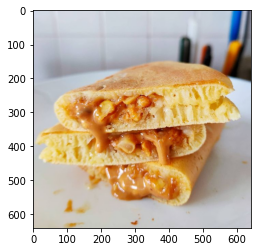

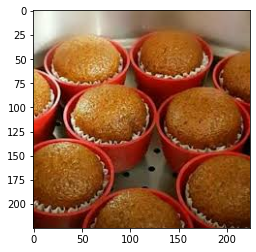

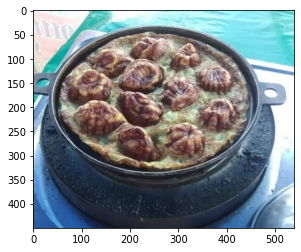

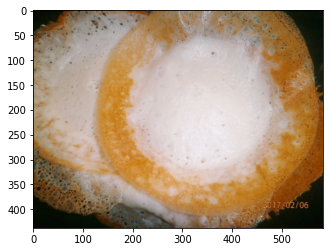

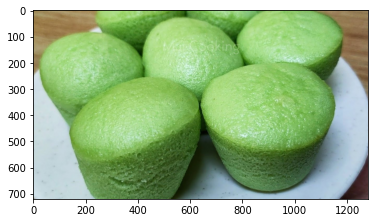

In [2]:
DATADIR = "gdrive/MyDrive/Apam Image"

CATEGORIES = ["Apam balik", "Apam gula hangus", "Apam lambung", "Apam manis", "Apam pandan"]

for category in CATEGORIES:
  path = os.path.join(DATADIR, category)
  for img in os.listdir(path):
    img_array = cv2.cvtColor(cv2.imread(os.path.join(path,img)), cv2.COLOR_BGR2RGB)
    plt.imshow(img_array, cmap='gray')
    plt.show()
    break

In [3]:
print(img_array)

[[[161 133  83]
  [159 131  81]
  [157 130  77]
  ...
  [141 119  80]
  [144 122  83]
  [147 125  86]]

 [[161 133  83]
  [159 131  81]
  [157 130  77]
  ...
  [144 122  83]
  [145 123  84]
  [147 125  86]]

 [[159 133  82]
  [158 132  81]
  [156 130  79]
  ...
  [147 125  86]
  [147 125  86]
  [146 124  85]]

 ...

 [[149 144 125]
  [152 149 130]
  [161 158 143]
  ...
  [101  75  78]
  [100  74  77]
  [ 99  73  76]]

 [[144 137 118]
  [148 143 123]
  [154 148 132]
  ...
  [ 98  72  75]
  [ 99  70  74]
  [ 98  69  73]]

 [[140 134 112]
  [144 137 118]
  [148 142 126]
  ...
  [102  76  79]
  [103  74  78]
  [102  73  77]]]


In [4]:
print(img_array.shape)

(720, 1280, 3)


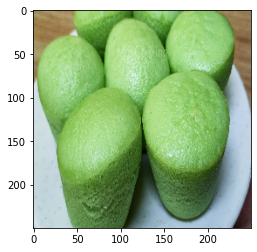

In [5]:
IMG_SIZE = 250

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

In [ ]:

training_data = []

def create_training_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(DATADIR,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.cvtColor(cv2.imread(os.path.join(path,img)), cv2.COLOR_BGR2RGB)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

print("")
print(len(training_data))

 60%|██████    | 30/50 [00:09<00:06,  3.27it/s]

In [ ]:
import random

random.shuffle(training_data)

index = 1
for sample in training_data:
  print(str(index) + "->" + str(sample[1]))
  index = index + 1

In [ ]:

X = []
y = []
labelArray = np.empty(len(training_data), dtype=int)
counter = 0
for features, label in training_data:
  X.append(features)
  #y.append(label)
  labelArray[counter] = label
  counter+=1

encoder = LabelEncoder()
encoder.fit(labelArray)
encoded_Y = encoder.transform(labelArray)
# convert integers to dummy variables (i.e. one hot encoded)
y = np_utils.to_categorical(encoded_Y)

print(y)

In [ ]:
print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 3))

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)
X = X/255.0

In [ ]:
#model = create_model()

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential()
model.add(keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)))  # 250x250 RGB images
model.add(layers.Conv2D(32, 5, strides=2, activation="relu"))
model.add(layers.Conv2D(32, 3, activation="relu"))
model.add(layers.MaxPooling2D(3))

# Can you guess what the current output shape is at this point? Probably not.
# Let's just print it:
model.summary()

# The answer was: (40, 40, 32), so we can keep downsampling...

model.add(layers.Conv2D(32, 3, activation="relu"))
model.add(layers.Conv2D(32, 3, activation="relu"))
model.add(layers.MaxPooling2D(3))
model.add(layers.Conv2D(32, 3, activation="relu"))
model.add(layers.Conv2D(32, 3, activation="relu"))
model.add(layers.MaxPooling2D(2))

# And now?
model.summary()

# Now that we have 4x4 feature maps, time to apply global max pooling.
model.add(layers.GlobalMaxPooling2D())

# Finally, we add a classification layer.
model.add(layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
#print(model.summary())

In [ ]:
history = model.fit(X, y, validation_split=0.3, epochs=10, batch_size=50)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [ ]:
history = model.evaluate(X, y, verbose=1)